In [3]:
import os
import time
import shutil
import pathlib
import itertools
import cv2
from sklearn.metrics import accuracy_score


import numpy as np
import pandas as pd
from PIL import Image

import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import tensorflow as tf
from tensorflow.keras.applications.efficientnet import EfficientNetB3, preprocess_input as efficientnet_preprocess, decode_predictions as efficientnet_decode #image size 300*300
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input as resnet_preprocess, decode_predictions as resnet_decode #224, 224, 3)
from tensorflow.keras.applications.xception import Xception, preprocess_input as xception_preprocess, decode_predictions as xception_decode  #299x299.
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout, BatchNormalization
from tensorflow.keras import regularizers

print("done")

2024-04-25 10:43:16.583922: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-25 10:43:16.584033: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-25 10:43:16.716012: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


done


In [4]:
# Generate data paths with labels
data_dir = "/kaggle/input/images-dataset/data/"
filepaths = []
labels = []

folds = os.listdir(data_dir)
folds = [folder for folder in folds if folder != 'data']
for fold in folds:
    foldpath = os.path.join(data_dir, fold)
    filelist = os.listdir(foldpath)
    for file in filelist:
        fpath = os.path.join(foldpath, file)
        filepaths.append(fpath)
        labels.append(fold)

# Concatenate data paths with labels into one dataframe
Fseries = pd.Series(filepaths, name= 'filepaths')
Lseries = pd.Series(labels, name='labels')
df = pd.concat([Fseries, Lseries], axis= 1)

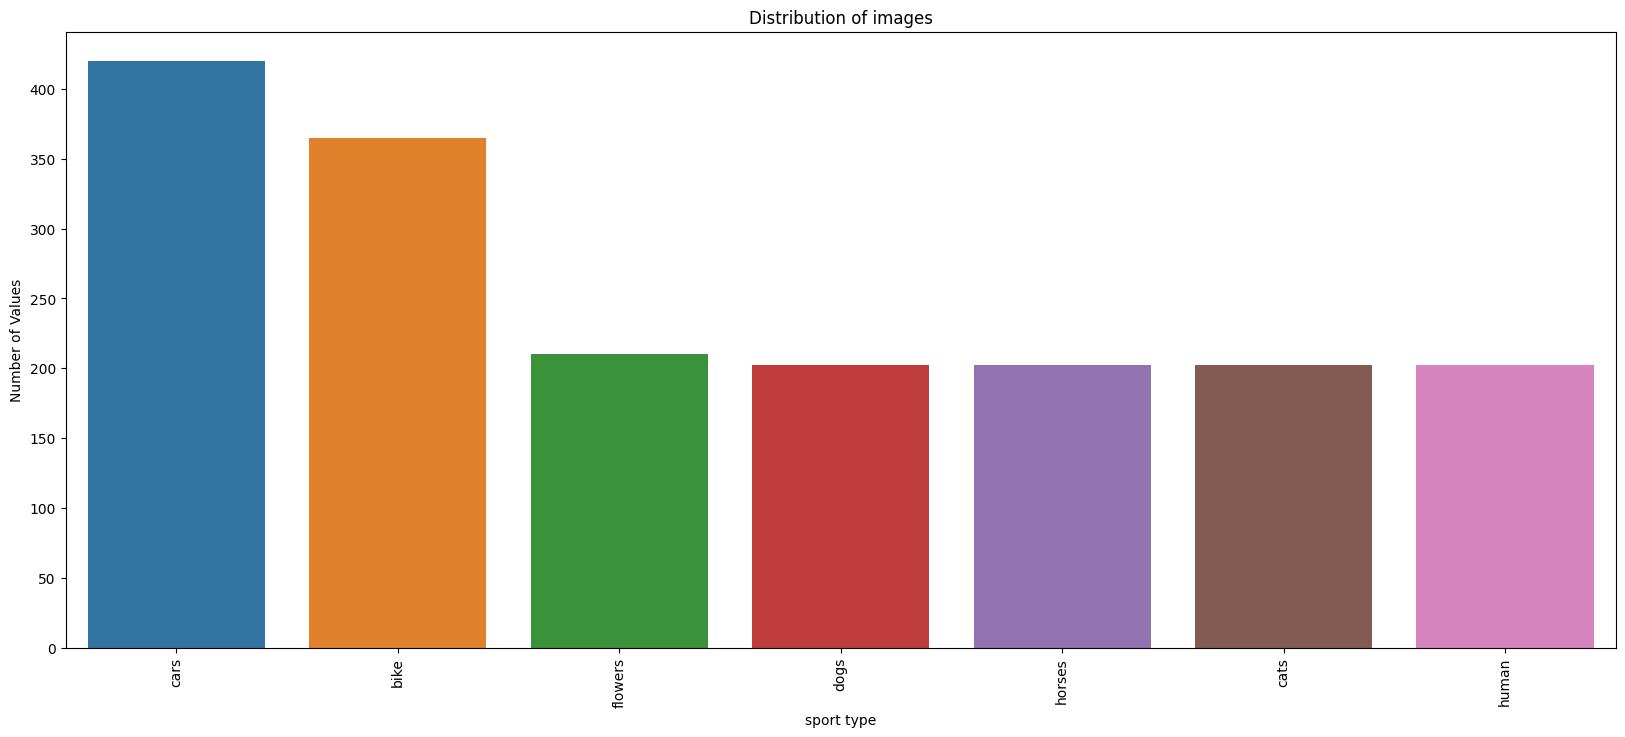

In [5]:
class_counts = df['labels'].value_counts()
plt.figure(figsize=(20, 8)) 
sns.barplot(x=class_counts.index, y=class_counts.values)

plt.xlabel('sport type')  
plt.ylabel('Number of Values') 
plt.title('Distribution of images')  
plt.xticks(rotation=90)
plt.show()  # Display the plot

In [6]:
colname = df['labels']
train_df, dummy_df = train_test_split(df,  train_size= 0.8, shuffle= True, random_state= 123, stratify= colname)

# valid and test dataframe
colname = dummy_df['labels']
valid_df, test_df = train_test_split(dummy_df,  train_size= 0.5, shuffle= True, random_state= 123, stratify= colname)

In [7]:
batch_size = 16
img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)

tr_gen = ImageDataGenerator()
ts_gen = ImageDataGenerator()

train_gen = tr_gen.flow_from_dataframe( train_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= True, batch_size= batch_size)

valid_gen = ts_gen.flow_from_dataframe( valid_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= True, batch_size= batch_size)

test_gen = ts_gen.flow_from_dataframe( test_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= False, batch_size= batch_size)

Found 1442 validated image filenames belonging to 7 classes.
Found 180 validated image filenames belonging to 7 classes.
Found 181 validated image filenames belonging to 7 classes.


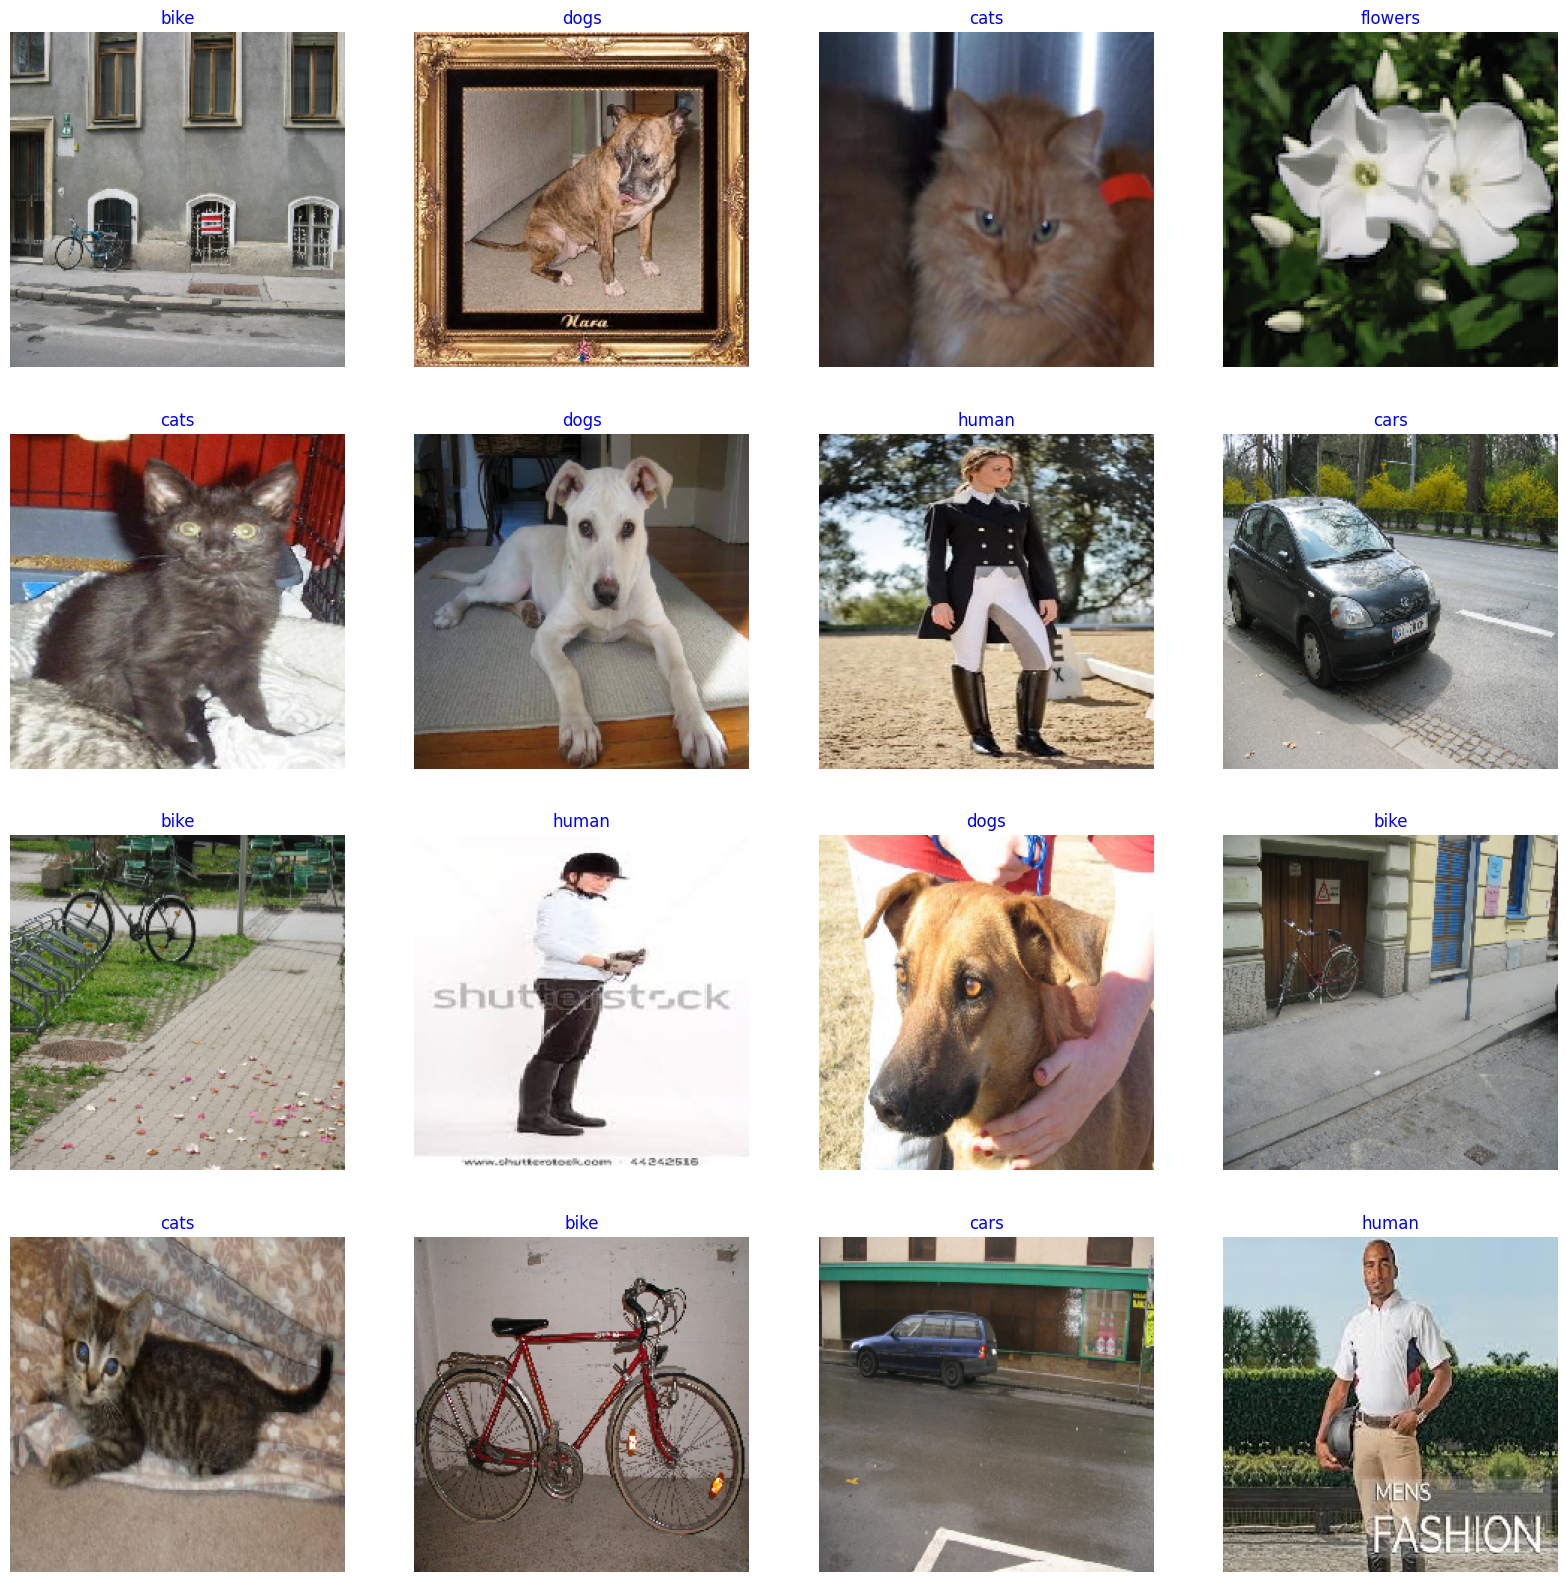

In [8]:
g_dict = train_gen.class_indices     # defines dictionary {'class': index}
classes = list(g_dict.keys())       # defines list of dictionary's kays (classes), classes names : string
images, labels = next(train_gen)      # get a batch size samples from the generator

plt.figure(figsize= (20, 20))

for i in range(16):
    plt.subplot(4, 4, i + 1)
    image = images[i] / 255       # scales data to range (0 - 255)
    plt.imshow(image)
    index = np.argmax(labels[i])  # get image index
    class_name = classes[index]   # get class of image
    plt.title(class_name, color= 'blue', fontsize= 12)
    plt.axis('off')
plt.show()


In [9]:
img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)
class_count = len(list(train_gen.class_indices.keys())) 

# create pre-trained model (you can built on pretrained model such as :  efficientnet, VGG , Resnet )
# we will use efficientnetb3 from EfficientNet family.
base_model = tf.keras.applications.efficientnet.EfficientNetB5(include_top= False, weights= "imagenet", input_shape= img_shape, pooling= 'max')
base_model.trainable = False

model1 = Sequential([
    keras.layers.InputLayer( input_shape=img_shape,),
    base_model,
    BatchNormalization(axis= -1, momentum= 0.99, epsilon= 0.001),
    Dense(128, kernel_regularizer= regularizers.l2( 0.01), activity_regularizer= regularizers.l1(0.001),
                bias_regularizer= regularizers.l1(0.001), activation= 'relu'),
    Dropout(rate= 0.4, seed= 123),
    Dense(class_count, activation= 'softmax')
])


model1.compile(Adamax(learning_rate= 0.01), loss= 'categorical_crossentropy', metrics= ['accuracy'])

model1.summary()

115263384/115263384 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/input_layer.py:25: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ efficientnetb5 (Functional)     │ (None, 2048)           │    28,513,527 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 2048)           │         8,192 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 7)              │           903 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 28,784,894 (109.81 MB)

 Trainable params: 267,271 (1.02 MB)

 Non-trainable params: 28,517,623 (108.79 MB)

In [10]:
epochs = 35
callbacks = [
    keras.callbacks.EarlyStopping(
        monitor='val_accuracy',  # monitor validation accuracy
        patience=13,  
        verbose=1,  # verbosity
        restore_best_weights=True  # restore best weights when stopping
    )
]

history = model1.fit(
    x=train_gen,
    epochs=epochs,
    verbose=1,
    validation_data=valid_gen,
    callbacks=callbacks,  
    shuffle=True
)


print("Best validation accuracy:", max(history.history['val_accuracy']))

Epoch 1/35


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


 1/91 ━━━━━━━━━━━━━━━━━━━━ 2:33:28 102s/step - accuracy: 0.0625 - loss: 6.1261

I0000 00:00:1714041919.032077     117 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1714041919.162455     117 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 841ms/step - accuracy: 0.7388 - loss: 7.6238

W0000 00:00:1714042008.882955     117 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


91/91 ━━━━━━━━━━━━━━━━━━━━ 204s 1s/step - accuracy: 0.7400 - loss: 7.6060 - val_accuracy: 0.9556 - val_loss: 3.1838
Epoch 2/35
91/91 ━━━━━━━━━━━━━━━━━━━━ 6s 64ms/step - accuracy: 0.9362 - loss: 2.7901 - val_accuracy: 0.9556 - val_loss: 1.8034
Epoch 3/35
91/91 ━━━━━━━━━━━━━━━━━━━━ 6s 67ms/step - accuracy: 0.9617 - loss: 1.6961 - val_accuracy: 0.9667 - val_loss: 1.2438
Epoch 4/35
91/91 ━━━━━━━━━━━━━━━━━━━━ 6s 63ms/step - accuracy: 0.9526 - loss: 1.2095 - val_accuracy: 0.9556 - val_loss: 0.9689
Epoch 5/35
91/91 ━━━━━━━━━━━━━━━━━━━━ 6s 63ms/step - accuracy: 0.9570 - loss: 1.0231 - val_accuracy: 0.9500 - val_loss: 0.8632
Epoch 6/35
91/91 ━━━━━━━━━━━━━━━━━━━━ 6s 64ms/step - accuracy: 0.9608 - loss: 0.9455 - val_accuracy: 0.9667 - val_loss: 0.7623
Epoch 7/35
91/91 ━━━━━━━━━━━━━━━━━━━━ 6s 64ms/step - accuracy: 0.9623 - loss: 0.8434 - val_accuracy: 0.9500 - val_loss: 0.7769
Epoch 8/35
91/91 ━━━━━━━━━━━━━━━━━━━━ 6s 67ms/step - accuracy: 0.9580 - loss: 0.8155 - val_accuracy: 0.9833 - val_loss: 0.

In [25]:
batch_size = 16
img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)

tr_gen = ImageDataGenerator()
ts_gen = ImageDataGenerator()

train_gen = tr_gen.flow_from_dataframe( train_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= True, batch_size= batch_size)

valid_gen = ts_gen.flow_from_dataframe( valid_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= True, batch_size= batch_size)

test_gen = ts_gen.flow_from_dataframe( test_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= False, batch_size= batch_size)

Found 1442 validated image filenames belonging to 7 classes.
Found 180 validated image filenames belonging to 7 classes.
Found 181 validated image filenames belonging to 7 classes.


In [26]:
img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)
class_count = len(list(train_gen.class_indices.keys())) 

# Create pre-trained ResNet-50 model with ImageNet weights
base_model = tf.keras.applications.ResNet50(
    include_top=False,
    weights="imagenet",
    input_shape=img_shape,
    pooling='max'  # Using 'max' to get a single vector output
)

# Freeze the base model to retain pre-trained features
base_model.trainable = False

# Create a new Sequential model with the given structure
model2 = Sequential([
     keras.layers.InputLayer( input_shape=img_shape,),
    base_model,
    BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001),
    Dense(256, kernel_regularizer=regularizers.l2(0.001), activity_regularizer=regularizers.l1(0.001),
          bias_regularizer=regularizers.l1(0.001), activation='relu'),
    Dropout(rate=0.35, seed=123),
    Dense(class_count, activation='softmax')  # Output layer for multi-class classification
])

# Compile the model with categorical cross-entropy and Adamax optimizer
model2.compile(optimizer=Adamax(learning_rate=0.005), loss='categorical_crossentropy', metrics=['accuracy'])

# Display the model summary
model2.summary()

/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/input_layer.py:25: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)           │ (None, 2048)           │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_14          │ (None, 2048)           │         8,192 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 256)            │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 7)              │         1,799 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,122,247 (92.02 MB)

 Trainable params: 530,439 (2.02 MB)

 Non-trainable params: 23,591,808 (90.00 MB)

In [27]:
epochs = 35
callbacks = [
    keras.callbacks.EarlyStopping(
        monitor='val_accuracy',  # monitor validation accuracy
        patience=13,  
        verbose=1,  # verbosity
        restore_best_weights=True  # restore best weights when stopping
    )
]

history2 = model2.fit(
    x=train_gen,
    epochs=epochs,
    verbose=1,
    validation_data=valid_gen,
    callbacks=callbacks,  
    shuffle=True
)


print("Best validation accuracy:", max(history.history['val_accuracy']))

Epoch 1/35


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


91/91 ━━━━━━━━━━━━━━━━━━━━ 35s 215ms/step - accuracy: 0.8258 - loss: 4.2440 - val_accuracy: 0.9500 - val_loss: 2.5020
Epoch 2/35
91/91 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - accuracy: 0.9748 - loss: 1.3686 - val_accuracy: 0.9778 - val_loss: 1.1817
Epoch 3/35
91/91 ━━━━━━━━━━━━━━━━━━━━ 5s 49ms/step - accuracy: 0.9882 - loss: 1.1071 - val_accuracy: 0.9722 - val_loss: 1.0136
Epoch 4/35
91/91 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - accuracy: 0.9872 - loss: 1.0105 - val_accuracy: 0.9778 - val_loss: 0.8985
Epoch 5/35
91/91 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - accuracy: 0.9919 - loss: 0.9103 - val_accuracy: 0.9778 - val_loss: 0.8366
Epoch 6/35
91/91 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - accuracy: 0.9947 - loss: 0.8523 - val_accuracy: 0.9778 - val_loss: 0.7608
Epoch 7/35
91/91 ━━━━━━━━━━━━━━━━━━━━ 5s 46ms/step - accuracy: 0.9860 - loss: 0.7971 - val_accuracy: 0.9722 - val_loss: 0.7171
Epoch 8/35
91/91 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 0.9852 - loss: 0.7642 - val_accuracy: 0.9778 - val_loss: 

In [22]:
img_size = (299, 299)  # The typical input size for Xception
channels = 3
img_shape = (img_size[0], img_size[1], channels)
class_count = len(list(train_gen.class_indices.keys())) 

# Create pre-trained Xception model with ImageNet weights
base_model = tf.keras.applications.Xception(
    include_top=False,
    weights="imagenet",
    input_shape=img_shape,
    pooling='max'  # Using 'avg' pooling for the base model
)

# Freeze the base model to retain pre-trained features
base_model.trainable = False

# Create a new Sequential model with the specified structure
model3 = Sequential([
     keras.layers.InputLayer( input_shape=img_shape,),
    base_model,  # Use the pre-trained Xception model
    BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001),
    Dense(256, kernel_regularizer=regularizers.l2(0.01), activity_regularizer=regularizers.l1(0.001),
          bias_regularizer=regularizers.l1(0.006), activation='relu'),  # Custom Dense layer
    Dropout(rate=0.5, seed=123),  # Dropout for regularization
    Dense(class_count, activation='softmax')  # Output layer with 'softmax' for multi-class classification
])

# Compile the model with categorical cross-entropy and Adamax optimizer
model3.compile(optimizer=Adamax(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

# Display the model summary
model3.summary()

/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/input_layer.py:25: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ xception (Functional)           │ (None, 2048)           │    20,861,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_13          │ (None, 2048)           │         8,192 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 256)            │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 7)              │         1,799 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21,396,015 (81.62 MB)

 Trainable params: 530,439 (2.02 MB)

 Non-trainable params: 20,865,576 (79.60 MB)

In [98]:

batch_size = 16
img_size = (299, 299)
channels = 3
img_shape = (img_size[0], img_size[1], channels)

tr_gen = ImageDataGenerator()
ts_gen = ImageDataGenerator()
print(img_shape)
train_gen = tr_gen.flow_from_dataframe( train_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= True, batch_size= batch_size)

valid_gen = ts_gen.flow_from_dataframe( valid_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= True, batch_size= batch_size)

test_gen = ts_gen.flow_from_dataframe( test_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= False, batch_size= batch_size)

(299, 299, 3)
Found 1442 validated image filenames belonging to 7 classes.
Found 180 validated image filenames belonging to 7 classes.
Found 181 validated image filenames belonging to 7 classes.


(299, 299, 3)
Found 1442 validated image filenames belonging to 7 classes.
Found 180 validated image filenames belonging to 7 classes.
Found 181 validated image filenames belonging to 7 classes.


In [69]:
changeforxception()
epochs = 35
callbacks = [
    keras.callbacks.EarlyStopping(
        monitor='val_accuracy',  # monitor validation accuracy
        patience=13,  
        verbose=1,  # verbosity
        restore_best_weights=True  # restore best weights when stopping
    )
]

history3 = model3.fit(
    x=train_gen,
    epochs=epochs,
    verbose=1,
    validation_data=valid_gen,
    callbacks=callbacks,  
    shuffle=True
)


print("Best validation accuracy:", max(history.history['val_accuracy']))

Found 1442 validated image filenames belonging to 7 classes.
Found 180 validated image filenames belonging to 7 classes.
Found 181 validated image filenames belonging to 7 classes.
Epoch 1/35
91/91 ━━━━━━━━━━━━━━━━━━━━ 32s 208ms/step - accuracy: 0.5709 - loss: 1.9544 - val_accuracy: 0.5722 - val_loss: 1.8675
Epoch 2/35
91/91 ━━━━━━━━━━━━━━━━━━━━ 5s 52ms/step - accuracy: 0.6689 - loss: 1.6627 - val_accuracy: 0.6111 - val_loss: 1.8188
Epoch 3/35
91/91 ━━━━━━━━━━━━━━━━━━━━ 5s 49ms/step - accuracy: 0.6924 - loss: 1.5759 - val_accuracy: 0.6167 - val_loss: 1.7888
Epoch 4/35
91/91 ━━━━━━━━━━━━━━━━━━━━ 5s 50ms/step - accuracy: 0.7331 - loss: 1.5109 - val_accuracy: 0.6278 - val_loss: 1.8232
Epoch 5/35
91/91 ━━━━━━━━━━━━━━━━━━━━ 5s 50ms/step - accuracy: 0.7911 - loss: 1.3839 - val_accuracy: 0.6444 - val_loss: 1.7672
Epoch 6/35
91/91 ━━━━━━━━━━━━━━━━━━━━ 5s 48ms/step - accuracy: 0.8141 - loss: 1.3021 - val_accuracy: 0.6556 - val_loss: 1.7352
Epoch 7/35
91/91 ━━━━━━━━━━━━━━━━━━━━ 5s 47ms/step - ac

In [101]:
predictions = model3.predict(test_gen)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = []
for i in range(len(test_gen)):
    images, labels = test_gen[i]  # Get a batch
    true_classes.extend(np.argmax(labels, axis=1))  # Get the correct class indices

true_classes = np.array(true_classes)
accuracy3 = accuracy_score(true_classes, predicted_classes)

print("Test Accuracy for model 3:", accuracy3)

12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step
Test Accuracy for model 3: 0.6795580110497238


In [102]:
def plot_loss(history, model_name):
    plt.figure(figsize=(8, 6))
    plt.plot(history.history['loss'], label=f' model {model_name} Training Loss')
    plt.plot(history.history['val_loss'], label=f'model {model_name} Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title(f'{model_name} - Loss over Epochs')
    plt.legend()
    plt.grid(True)
    plt.show()

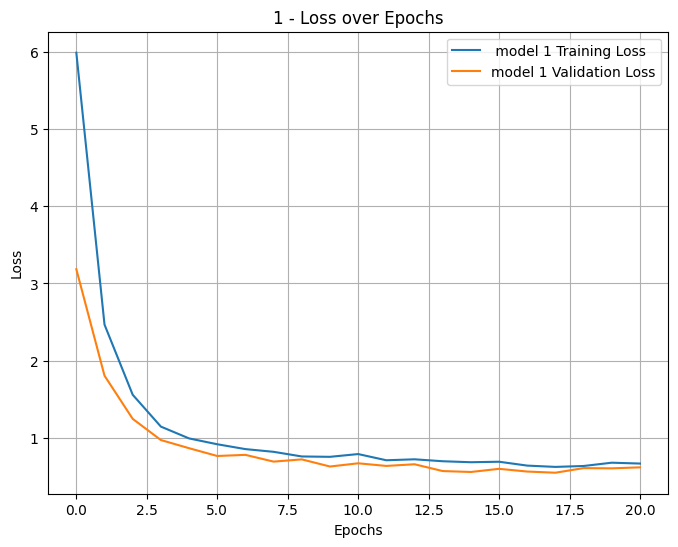

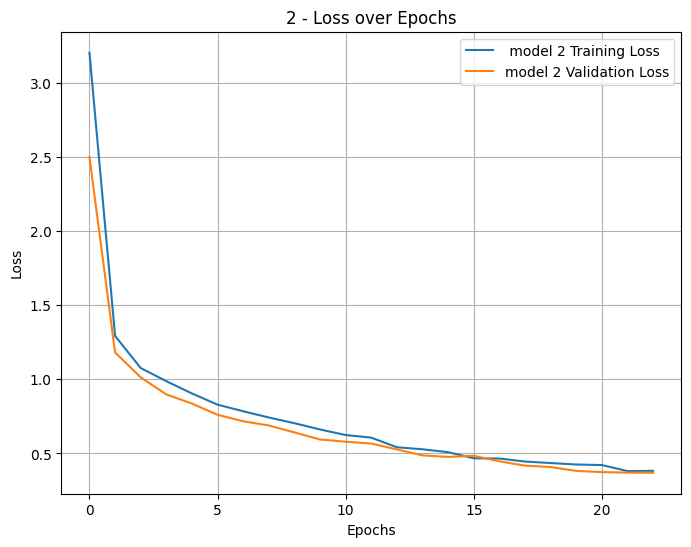

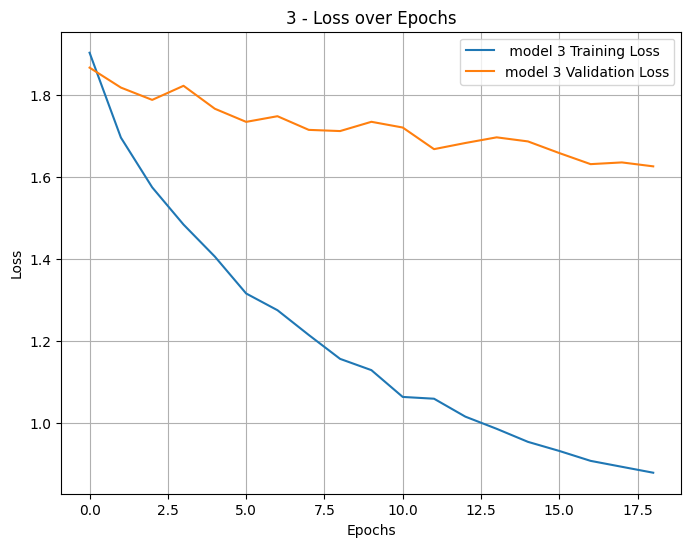

In [103]:

plot_loss(history, 1)

plot_loss(history2, 2)


plot_loss(history3, 3)



In [104]:
def plot_validation_accuracy(history):
    # Get the number of epochs
    epochs = range(1, len(history.history['val_accuracy']) + 1)

    # Plot validation accuracy and training accuracy
    plt.plot(epochs, history.history['val_accuracy'], label='Validation Accuracy')
    plt.plot(epochs, history.history['accuracy'], label='Training Accuracy')  # Optional
    plt.title('Validation and Training Accuracy over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

    # Get validation accuracies
    val_accuracies = history.history['val_accuracy']
    # Find the maximum validation accuracy and the epoch it occurred on
    best_val_accuracy = max(val_accuracies)
    best_val_epoch = val_accuracies.index(best_val_accuracy) + 1

    # Get training accuracies
    train_accuracies = history.history['accuracy']
    # Find the maximum training accuracy and the epoch it occurred on
    best_train_accuracy = max(train_accuracies)
    best_train_epoch = train_accuracies.index(best_train_accuracy) + 1

    # Print best validation accuracy with its epoch
    print("Best validation accuracy:", best_val_accuracy)
    print("Occurred at epoch:", best_val_epoch)

    # Print best training accuracy with its epoch
    print("Best training accuracy:", best_train_accuracy)
    print("Occurred at epoch:", best_train_epoch)


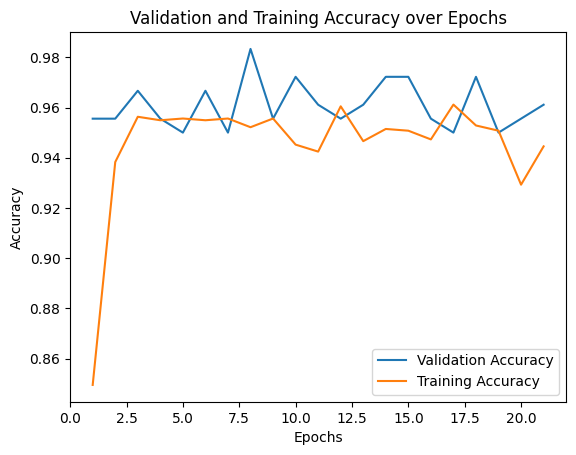

Best validation accuracy: 0.9833333492279053
Occurred at epoch: 8
Best training accuracy: 0.9611650705337524
Occurred at epoch: 17


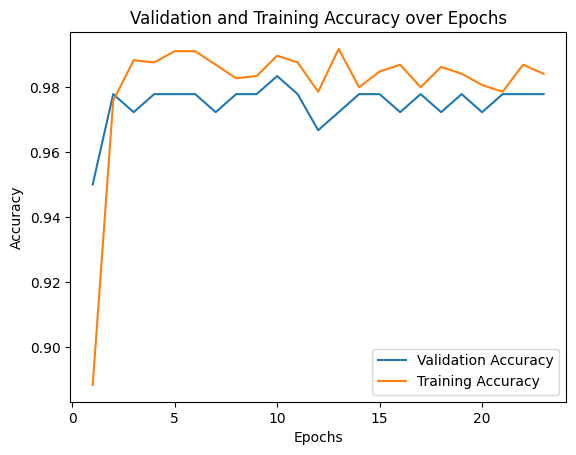

Best validation accuracy: 0.9833333492279053
Occurred at epoch: 10
Best training accuracy: 0.9916782379150391
Occurred at epoch: 13


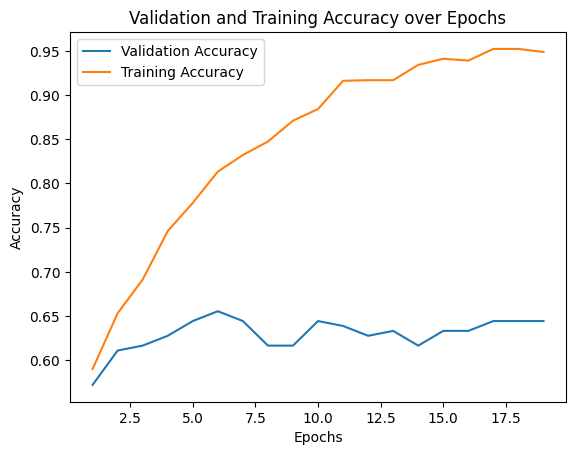

Best validation accuracy: 0.6555555462837219
Occurred at epoch: 6
Best training accuracy: 0.9521498084068298
Occurred at epoch: 17


In [105]:
plot_validation_accuracy(history)
plot_validation_accuracy(history2)  
plot_validation_accuracy(history3)  

In [108]:
batch_size = 16
img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)

tr_gen = ImageDataGenerator()
ts_gen = ImageDataGenerator()
test_gen = ts_gen.flow_from_dataframe( test_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= False, batch_size= batch_size)

Found 181 validated image filenames belonging to 7 classes.


In [109]:
predictions = model2.predict(test_gen)

predicted_classes = np.argmax(predictions, axis=1)
predictions = model2.predict(test_gen)
# Convert predictions to class indices
# Assuming this is a multi-class problem, find the index of the max value to get the predicted class
predicted_classes = np.argmax(predictions, axis=1)
true_classes = []
for i in range(len(test_gen)):
    images, labels = test_gen[i]  # Get a batch
    true_classes.extend(np.argmax(labels, axis=1))  # Get the correct class indices

true_classes = np.array(true_classes)
accuracy2 = accuracy_score(true_classes, predicted_classes)

print("Test Accuracy for model 2:", accuracy)
# accuracy1 = accuracy_score(y_train, predicted_classes)

# print("Training Accuracy:", accuracy)

 3/12 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step

/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step
Test Accuracy for model 2: 0.988950276243094


In [110]:
predictions = model1.predict(test_gen)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = []
for i in range(len(test_gen)):
    images, labels = test_gen[i]  # Get a batch
    true_classes.extend(np.argmax(labels, axis=1))  # Get the correct class indices

true_classes = np.array(true_classes)
accuracy = accuracy_score(true_classes, predicted_classes)

print("Test Accuracy for model 1:", accuracy)

12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step
Test Accuracy for model 1: 0.9834254143646409


In [114]:
bestaccuracy=max(accuracy,accuracy2,accuracy3)
bestaccuracy

0.988950276243094

In [121]:
if bestaccuracy == accuracy:
    print(f"model 1 has best acurracy with {bestaccuracy}")
elif bestaccuracy == accuracy2:
     print(f"model 2 has best acurracy with {bestaccuracy}")
elif bestaccuracy == accuracy3:
     print(f"model 3 has best acurracy with {bestaccuracy}")


model 2 has best acurracy with 0.988950276243094


## model 2 has best acurracy with 0.988950276243094  model 2 is built with Resnet50